In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Работа с данными 
import pandas as pd
import numpy as np

# Балансировка
from imblearn.over_sampling import SMOTE

# Разделение на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

# Классификаторы
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree

# Визуалцияция результатов обучения
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report

#Загрузка данных

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# импортируем датасеты
data = pd.read_csv(r'/content/drive/MyDrive/feature_data_new_mini.csv')

goal = pd.read_csv(r'/content/drive/MyDrive/goal_cipher.csv', index_col=0)
goal.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (113,116,119,122) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ser_loc,zns_loc,prs_loc,year_month,fail_place,fail_reason,fail_type,day
0,134,171.0,1.0,2021-01,Дуриан,Момордика,Мармеладный плод,12
3,134,166.0,1.0,2021-01,Маракуйя,Либерика,Салакка,12
4,240,1068.0,1.0,2021-01,Земляной орех,Абрикос,Пара-гуайява,5
7,240,2200.0,1.0,2021-01,Маракуйя,Гранат,Мармеладный плод,17
9,240,2734.0,1.0,2021-01,Земляной орех,Бананы,Гнетум гнемон,4


#Чистка данных

In [5]:
print(len(data.index))
data = data.drop_duplicates() # удаляем дубликаты 
print(len(data.index))

45418
43855


#Сравнение дата сетов

In [6]:
data.head()

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к_y,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent
0,107,3.0,1.0,2020-01-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
1,107,3.0,1.0,2019-03-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
2,107,4.0,1.0,2020-04-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,0.0,0.0
3,107,4.0,1.0,2020-06-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,6.0,6.0
4,107,4.0,1.0,2020-07-28,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,10.0,10.0


In [7]:
goal.head()

,ser_loc,zns_loc,prs_loc,year_month,fail_place,fail_reason,fail_type,day
0,134,171.0,1.0,2021-01,Дуриан,Момордика,Мармеладный плод,12
3,134,166.0,1.0,2021-01,Маракуйя,Либерика,Салакка,12
4,240,1068.0,1.0,2021-01,Земляной орех,Абрикос,Пара-гуайява,5
7,240,2200.0,1.0,2021-01,Маракуйя,Гранат,Мармеладный плод,17
9,240,2734.0,1.0,2021-01,Земляной орех,Бананы,Гнетум гнемон,4


#Выделяем целевой массив

In [8]:
goal = goal[goal['fail_reason'] == 'Барбадин (Большая гранадилла)']
print(goal)

        ser_loc  zns_loc  prs_loc year_month fail_place  \
811         240   2742.0      1.0    2021-01  Карамбола   
826         244    157.0      1.0    2021-01  Карамбола   
1035        240   2524.0      2.0    2021-01  Карамбола   
1724        145    990.0      1.0    2021-01  Карамбола   
3315        240    356.0      1.0    2021-02  Карамбола   
...         ...      ...      ...        ...        ...   
146409      145    284.0      1.0    2018-09  Карамбола   
146706      145    513.0      1.0    2018-09  Карамбола   
146779      145    573.0      1.0    2018-09  Карамбола   
146865      145    445.0      1.0    2018-09  Карамбола   
147188      145    575.0      1.0    2018-09  Карамбола   

                          fail_reason         fail_type  day  
811     Барбадин (Большая гранадилла)        Помпельмус    5  
826     Барбадин (Большая гранадилла)        Помпельмус   12  
1035    Барбадин (Большая гранадилла)        Помпельмус   21  
1724    Барбадин (Большая гранадилла)  

#Готовим данные к объединению

In [9]:
goal['year_month'] = pd.to_datetime(goal['year_month'])

<ipython-input-9-1421ae58db84>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goal['year_month'] = pd.to_datetime(goal['year_month'])


In [10]:
goal = goal[['ser_loc','zns_loc','prs_loc','year_month', 'day']]

goal['day'] = [int(x) for x in goal['day']]

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
goal['year_month'] = pd.to_datetime(goal['year_month'], format='%Y-%m')

data['year_month'] = data['year_month'].dt.to_period('M')
goal['year_month'] = goal['year_month'].dt.to_period('M')

data.head()

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к_y,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent
0,107,3.0,1.0,2020-01,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
1,107,3.0,1.0,2019-03,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
2,107,4.0,1.0,2020-04,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,0.0,0.0
3,107,4.0,1.0,2020-06,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,6.0,6.0
4,107,4.0,1.0,2020-07,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,10.0,10.0


#Объединяем массивы

In [11]:
data_new = data.merge(goal, on = ['ser_loc','zns_loc','prs_loc','year_month'], how = 'outer')
data_new.head()

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent,day
0,107,3.0,1.0,2020-01,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0,NaN
1,107,3.0,1.0,2019-03,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0,NaN
2,107,4.0,1.0,2020-04,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,0.0,0.0,NaN
3,107,4.0,1.0,2020-06,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,6.0,6.0,NaN
4,107,4.0,1.0,2020-07,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,10.0,10.0,NaN


#Ищем и чистим плохие столбцы

In [12]:
data_new = data_new.dropna(subset = ['count_fail'])

In [13]:
i = 0
for col_name in data.columns:
    if col_name.find('_x_') == True:
        print(i)
    i += 1 

In [14]:
data_new = data_new.drop(columns=['date_repair_finish_y_1',
       'date_repair_finish_x_2',
       'date_repair_finish_y_2', 'date_repair_finish', 
       'date_repair_finish_x_1'])

#Подготовка данных к классификации

In [15]:
data_new['day'] = [1 if x > 0 else 0 for x in data_new['day']]
data_new = data_new.set_index(['ser_loc','zns_loc','prs_loc','year_month'])

In [16]:
print('Кол-во пустых ячеек: ',data_new.isnull().sum().sum())
print('Кол-во строк в датасете: ',len(data_new.index))

Кол-во пустых ячеек:  82
Кол-во строк в датасете:  43855


In [17]:
data_new.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [18]:
print('Кол-во пустых ячеек: ',data_new.isnull().sum().sum())
print('Кол-во строк в датасете: ',len(data_new.index))

Кол-во пустых ячеек:  0
Кол-во строк в датасете:  43854


In [19]:
X=data_new.drop(columns="day")
y=data_new["day"]

In [20]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# model=scaler.fit(X)
# X_sc=model.transform(X)
 
# print(X_sc)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)#

#Метрика качества на несбалансированных данных

In [22]:
model_t = tree.DecisionTreeClassifier(criterion='gini', random_state=42,max_depth=2).fit(X_train,np.ravel(y_train))
y_train_tree=model_t.predict(X_train)
y_train_proba_tree=model_t.predict_proba(X_train)
y_test_tree=model_t.predict(X_test)
y_test_proba_tree=model_t.predict_proba(X_test)

Confusion Matrix Дерево решений


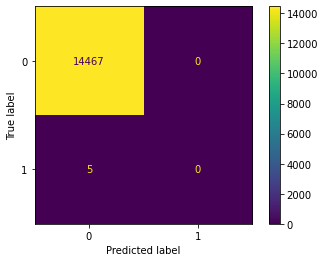

In [23]:
print('Confusion Matrix Дерево решений')
cm_tree = confusion_matrix(y_test, y_test_tree, labels=model_t.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=model_t.classes_)
disp_tree.plot()
plt.show()

In [24]:
TREE_CLR=classification_report(y_test,y_test_tree)
print("Метрики Деревья решений на тестовой выборке")
print(TREE_CLR)

Метрики Деревья решений на тестовой выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14467
           1       0.00      0.00      0.00         5

    accuracy                           1.00     14472
   macro avg       0.50      0.50      0.50     14472
weighted avg       1.00      1.00      1.00     14472



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
d = {'day':y_test}
Predict_test = pd.DataFrame(data=d)
Predict_test['predict'] = y_test_tree
print('Верно спрогнозированное событие, %: ', len(Predict_test[(Predict_test['predict'] == 1)&(Predict_test['day'] == 1)].index)/len(Predict_test[Predict_test['day'] == 1].index))
print('Верно спрогнозированное отсуствие события, %: ', len(Predict_test[(Predict_test['predict'] == 0)&(Predict_test['day'] == 0)].index)/len(Predict_test[Predict_test['day'] == 0].index))

Верно спрогнозированное событие, %:  0.0
Верно спрогнозированное отсуствие события, %:  1.0


In [26]:
data_new['day'].value_counts()

0    43840
1       14
Name: day, dtype: int64

In [27]:
# балансировка
sm = SMOTE (random_state=1000)#random state=42, k n =6
X_train_res, y_train_res = sm.fit_resample(X, y)# X_train, y_train

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_train_res,y_train_res,random_state=1)

In [29]:
print(type(y_train_res))
y_train_res_numpy = y_train_res. to_numpy () 
print(y_train_res_numpy)

<class 'pandas.core.series.Series'>
[0 0 0 ... 1 1 1]


In [30]:
number_of_1_day=0
number_of_2_day=0
for i in y_train_res_numpy:
  if i==0:
    number_of_1_day=number_of_1_day+1
  elif i==1:
    number_of_2_day=number_of_2_day+1
print(number_of_1_day,number_of_2_day)

43840 43840


In [59]:
# Импорт библиотек
from sklearn.decomposition import PCA

 # Обучаем PCA для выделения 6 признаков
pca = PCA(n_components=6)
pca.fit(X_train)
 # Изменяем наши наборы данных под выбранные признаки
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [60]:
explained_variance = pca.explained_variance_ratio_ 

print(explained_variance)
print("                                                                                                                                   ")

X_train_df=df = pd.DataFrame(X_train) 
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            data_new.columns)))

principalComponents = pca.fit_transform(X_train)


[6.47976859e-01 2.93095787e-01 4.95984158e-02 8.60572208e-03
 4.39528497e-04 2.41388771e-04]
                                                                                                                                   
1 component: 64.8% of initial variance
0.000 x count_fail + -0.000 x 107_repair_count + -0.000 x 307_repair_count + -0.000 x 308_repair_count + -0.000 x 309_repair_count + -0.000 x 521_repair_count + 0.000 x 800_repair_count + -0.000 x 801_repair_count + -0.000 x автоматический перевод в нр при превышении норм на то-2 + -0.000 x износ тормозной колодки свыше допустимого + -0.000 x межвитковое замыкание обмотки + 0.000 x неисправность быстродействующего выключателя + 0.000 x неисправность водяной системы охлаждения дизеля + -0.000 x неисправность воздухораспределителя + -0.000 x неисправность выпрямительной установки + 0.000 x неисправность главного выключателя + -0.000 x неисправность крана машиниста + -0.000 x неисправность крышевого оборудования + -0.000 x неиспр

#GradientBoostingClassifier

In [79]:
model_gradboost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42).fit(X_train_pca, np.ravel(y_train))

y_train_gradboost=model_gradboost.predict(X_train_pca)
y_test_gradboost=model_gradboost.predict(X_test_pca)

In [81]:
val_score = model_gradboost.score(X_test_pca, y_test) # val (test) score
val_score

0.9215328467153284

Confusion Matrix Градиентный бустинг


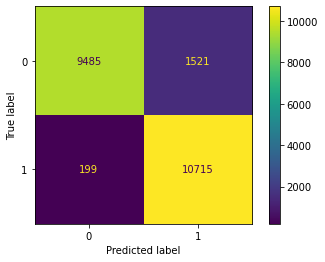

In [62]:
print('Confusion Matrix Градиентный бустинг')
cm_gb = confusion_matrix(y_test, y_test_gradboost, labels=model_gradboost.classes_)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=model_gradboost.classes_)
disp_gb.plot()
plt.show()

In [63]:
GB_CLR=classification_report(y_test,y_test_gradboost)
print("Метрики Градиентный бустинг на тестовой выборке")
print(GB_CLR)

Метрики Градиентный бустинг на тестовой выборке
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     11006
           1       0.88      0.98      0.93     10914

    accuracy                           0.92     21920
   macro avg       0.93      0.92      0.92     21920
weighted avg       0.93      0.92      0.92     21920



In [64]:
d = {'day':y_test}
Predict_test = pd.DataFrame(data=d)
Predict_test['predict'] = y_test_gradboost
print('Верно спрогнозированное событие, %: ', len(Predict_test[(Predict_test['predict'] == 1)&(Predict_test['day'] == 1)].index)/len(Predict_test[Predict_test['day'] == 1].index))
print('Верно спрогнозированное отсуствие события, %: ', len(Predict_test[(Predict_test['predict'] == 0)&(Predict_test['day'] == 0)].index)/len(Predict_test[Predict_test['day'] == 0].index))

Верно спрогнозированное событие, %:  0.9817665383910573
Верно спрогнозированное отсуствие события, %:  0.8618026530983101


#Случайный лес

In [65]:
model_rf = RandomForestClassifier(n_estimators=10, 
                                  random_state=42, max_depth=40, bootstrap='false').fit(X_train_pca, np.ravel(y_train))

y_train_rf=model_rf.predict(X_train_pca)
y_train_proba_rf=model_rf.predict_proba(X_train_pca)
y_test_rf=model_rf.predict(X_test_pca)
y_test_proba_rf_=model_rf.predict_proba(X_test_pca)

In [82]:
val_score = model_gradboost.score(X_test_pca, y_test) # val (test) score
val_score

0.9215328467153284

Confusion Matrix Случайный лес


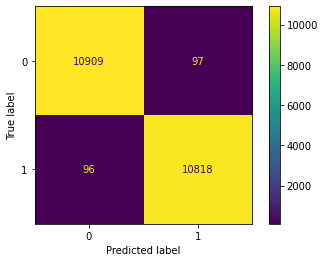

In [66]:
print('Confusion Matrix Случайный лес')
cm_rf = confusion_matrix(y_test, y_test_rf, labels=model_rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=model_rf.classes_)
disp_rf.plot()
plt.show()

In [67]:
RF_CLR=classification_report(y_test,y_test_rf)
print("Метрики Случайный лес на тестовой выборке")
print(RF_CLR)

Метрики Случайный лес на тестовой выборке
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11006
           1       0.99      0.99      0.99     10914

    accuracy                           0.99     21920
   macro avg       0.99      0.99      0.99     21920
weighted avg       0.99      0.99      0.99     21920



In [68]:
d = {'day':y_test}
Predict_test = pd.DataFrame(data=d)
Predict_test['predict'] = y_test_rf
print('Верно спрогнозированное событие, %: ', len(Predict_test[(Predict_test['predict'] == 1)&(Predict_test['day'] == 1)].index)/len(Predict_test[Predict_test['day'] == 1].index))
print('Верно спрогнозированное отсуствие события, %: ', len(Predict_test[(Predict_test['predict'] == 0)&(Predict_test['day'] == 0)].index)/len(Predict_test[Predict_test['day'] == 0].index))

Верно спрогнозированное событие, %:  0.9912039582188016
Верно спрогнозированное отсуствие события, %:  0.9911866254770125


#Дерево решений

In [69]:
model_t = tree.DecisionTreeClassifier(criterion='gini', random_state=42,max_depth=2).fit(X_train_pca,np.ravel(y_train))
y_train_tree=model_t.predict(X_train_pca)
y_train_proba_tree=model_t.predict_proba(X_train_pca)
y_test_tree=model_t.predict(X_test_pca)
y_test_proba_tree=model_t.predict_proba(X_test_pca)

In [ ]:
val_score = model_gradboost.score(X_test_pca, y_test) # val (test) score
val_score

Confusion Matrix Дерево решений


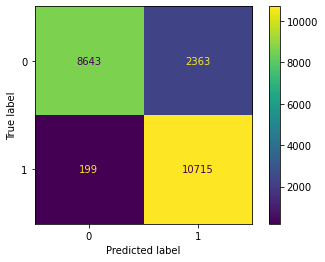

In [70]:
print('Confusion Matrix Дерево решений')
cm_tree = confusion_matrix(y_test, y_test_tree, labels=model_t.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=model_t.classes_)
disp_tree.plot()
plt.show()

In [71]:
TREE_CLR=classification_report(y_test,y_test_tree)
print("Метрики Деревья решений на тестовой выборке")
print(TREE_CLR)

Метрики Деревья решений на тестовой выборке
              precision    recall  f1-score   support

           0       0.98      0.79      0.87     11006
           1       0.82      0.98      0.89     10914

    accuracy                           0.88     21920
   macro avg       0.90      0.88      0.88     21920
weighted avg       0.90      0.88      0.88     21920



In [72]:
d = {'day':y_test}
Predict_test = pd.DataFrame(data=d)
Predict_test['predict'] = y_test_tree
print('Верно спрогнозированное событие, %: ', len(Predict_test[(Predict_test['predict'] == 1)&(Predict_test['day'] == 1)].index)/len(Predict_test[Predict_test['day'] == 1].index))
print('Верно спрогнозированное отсуствие события, %: ', len(Predict_test[(Predict_test['predict'] == 0)&(Predict_test['day'] == 0)].index)/len(Predict_test[Predict_test['day'] == 0].index))

Верно спрогнозированное событие, %:  0.9817665383910573
Верно спрогнозированное отсуствие события, %:  0.7852989278575323


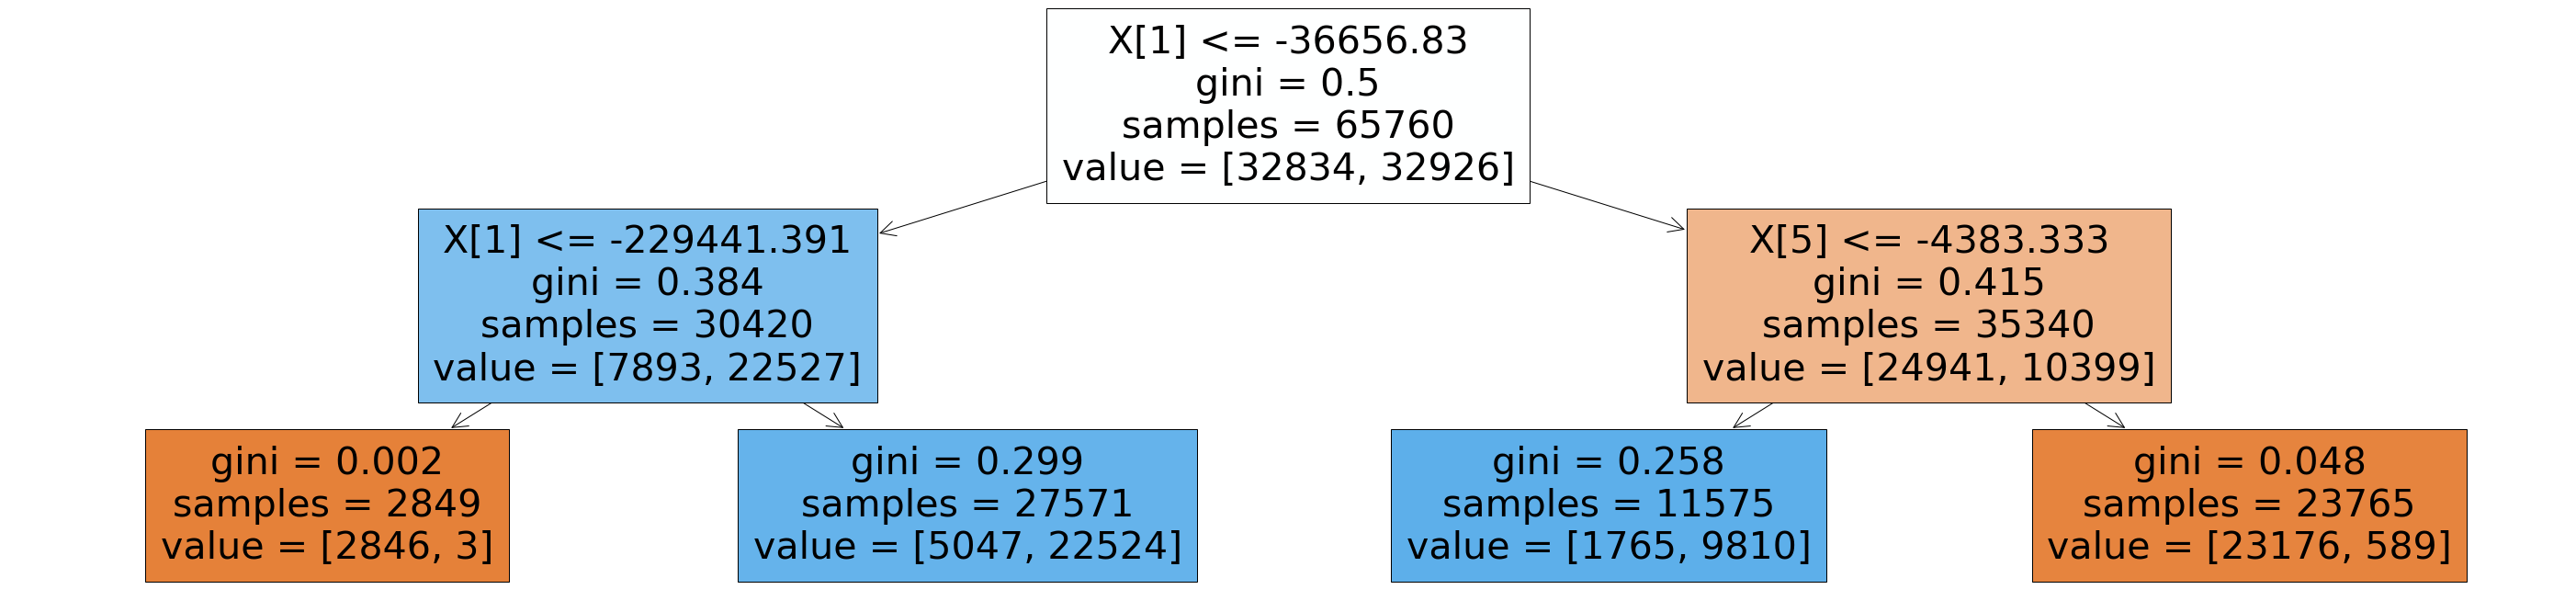

In [73]:
#Визуализация дерева
plt.figure(figsize=(50,12))
tree.plot_tree(model_t, filled='True')
plt.show()